# 基于谷歌搜索的大数据舆情分析策略

参考论文：https://www.nature.com/articles/srep01684

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import quandl
%matplotlib inline
import warnings; warnings.simplefilter('ignore') #忽略可能会出现的警告信息，警告并不是错误，可以忽略；

### 1. 策略思想


1.如果当周的谷歌Debt搜索量 > 过去三周平均，则做空道琼斯指数，持仓一周；



2.如果当周的谷歌Debt搜索量 < 过去三周平均，则做多道琼斯指数，持仓一周；


### 2. 数据整理

#### 2.1 读取论文数据

In [4]:
paper = pd.read_csv('data/paper_data.csv', 
                    sep=' ',
                    parse_dates=True)
paper.head()

,Google Start Date,Google End Date,arts,banking,bonds,bubble,buy,cancer,car,cash,...,trader,train,transaction,travel,unemployment,war,water,world,DJIA Date,DJIA Closing Price
0,2004-01-04,2004-01-10,0.956667,0.193333,0.203333,0.183333,2.41667,0.913333,4.19333,0.326667,...,0.346667,0.706667,0.050000,2.06000,0.336667,2.02000,1.91333,4.83333,2004-01-12,10485.18
1,2004-01-11,2004-01-17,0.970000,0.203333,0.186667,0.190000,2.31667,0.940000,4.22000,0.320000,...,0.346667,0.676667,0.050000,2.05333,0.296667,2.09333,1.93333,4.76667,2004-01-20,10528.66
2,2004-01-18,2004-01-24,0.926667,0.196667,0.190000,0.173333,2.35000,0.906667,4.10667,0.320000,...,0.356667,0.713333,0.056667,2.01333,0.310000,1.97333,1.89333,4.60000,2004-01-26,10702.51
3,2004-01-25,2004-01-31,0.950000,0.196667,0.180000,0.196667,2.26667,0.906667,3.99333,0.330000,...,0.336667,0.710000,0.060000,1.91333,0.296667,1.90667,1.92000,4.53333,2004-02-02,10499.18
4,2004-02-01,2004-02-07,0.893333,0.203333,0.183333,0.173333,2.08333,0.913333,3.84000,0.303333,...,0.326667,0.630000,0.050000,1.76667,0.290000,2.08667,1.88667,4.53333,2004-02-09,10579.03


In [5]:
data = pd.DataFrame({'Google_week': paper['Google End Date'],
                     'Debt': paper['debt'].astype(np.float64),
                     'Date': paper['DJIA Date'],
                     'DJClose': paper['DJIA Closing Price'].astype(np.float64)})

In [6]:
data.head()

,DJClose,Date,Debt,Google_week
0,10485.18,2004-01-12,0.210000,2004-01-10
1,10528.66,2004-01-20,0.210000,2004-01-17
2,10702.51,2004-01-26,0.210000,2004-01-24
3,10499.18,2004-02-02,0.213333,2004-01-31
4,10579.03,2004-02-09,0.200000,2004-02-07


In [7]:
data['Date'] = pd.to_datetime(data['Date'])               #转换为时间序列数据格式才能进行后续的合并等操作；

In [8]:
data['Google_week'] = pd.to_datetime(data['Google_week'])

#### 2.2 读取我们自己下载的谷歌搜索指数数据

注意：论文数据作者有自己做过处理，Normalize，虽然和我们自己下载的数据有非常高的相关性，但是仍然有差别；

In [10]:
trends_download = pd.read_csv('data/debt_google_trend.csv')
trends_download.head(10)

,Week,debt
0,2004-01-04 - 2004-01-10,63
1,2004-01-11 - 2004-01-17,60
2,2004-01-18 - 2004-01-24,61
3,2004-01-25 - 2004-01-31,63
4,2004-02-01 - 2004-02-07,61
5,2004-02-08 - 2004-02-14,59
6,2004-02-15 - 2004-02-21,56
7,2004-02-22 - 2004-02-28,57
8,2004-02-29 - 2004-03-06,55
9,2004-03-07 - 2004-03-13,60


In [14]:
trends_download['Week'] = trends_download['Week'].apply(lambda x: pd.to_datetime(x.split(' ')[-1]))
trends_download.head()

,Week,debt
0,2004-01-10,63
1,2004-01-17,60
2,2004-01-24,61
3,2004-01-31,63
4,2004-02-07,61


In [15]:
data.head()

,DJClose,Date,Debt,Google_week
0,10485.18,2004-01-12,0.210000,2004-01-10
1,10528.66,2004-01-20,0.210000,2004-01-17
2,10702.51,2004-01-26,0.210000,2004-01-24
3,10499.18,2004-02-02,0.213333,2004-01-31
4,10579.03,2004-02-09,0.200000,2004-02-07


In [16]:
all_data = pd.merge(data, trends_download, 
                 left_on='Google_week', right_on='Week')       #pandas知识内容；

In [17]:
all_data.head()

,DJClose,Date,Debt,Google_week,Week,debt
0,10485.18,2004-01-12,0.210000,2004-01-10,2004-01-10,63
1,10528.66,2004-01-20,0.210000,2004-01-17,2004-01-17,60
2,10702.51,2004-01-26,0.210000,2004-01-24,2004-01-24,61
3,10499.18,2004-02-02,0.213333,2004-01-31,2004-01-31,63
4,10579.03,2004-02-09,0.200000,2004-02-07,2004-02-07,61


In [19]:
all_data.drop('Week', inplace=True, axis=1)
all_data.set_index('Date', inplace=True)

In [20]:
all_data.head()

,DJClose,Debt,Google_week,debt
Date,,,,
2004-01-12,10485.18,0.210000,2004-01-10,63
2004-01-20,10528.66,0.210000,2004-01-17,60
2004-01-26,10702.51,0.210000,2004-01-24,61
2004-02-02,10499.18,0.213333,2004-01-31,63
2004-02-09,10579.03,0.200000,2004-02-07,61


In [21]:
all_data.rename(columns = {'Debt':'Debt_paper', 
                    'debt':'Debt_download'}, inplace = True)

In [22]:
all_data.head()

,DJClose,Debt_paper,Google_week,Debt_download
Date,,,,
2004-01-12,10485.18,0.210000,2004-01-10,63
2004-01-20,10528.66,0.210000,2004-01-17,60
2004-01-26,10702.51,0.210000,2004-01-24,61
2004-02-02,10499.18,0.213333,2004-01-31,63
2004-02-09,10579.03,0.200000,2004-02-07,61


In [23]:
both_trends = all_data[['Google_week', 'Debt_paper', 'Debt_download']].set_index('Google_week')
both_trends.head()

,Debt_paper,Debt_download
Google_week,,
2004-01-10,0.210000,63
2004-01-17,0.210000,60
2004-01-24,0.210000,61
2004-01-31,0.213333,63
2004-02-07,0.200000,61


In [24]:
#作者的数据是经过normalized的，跟我们再google trend数据库里面下载的数据是几乎一致的；
both_trends.corr()

,Debt_paper,Debt_download
Debt_paper,1.00000,0.95766
Debt_download,0.95766,1.00000


### 3. 交易信号和交易逻辑

In [25]:
all_data.head()

,DJClose,Debt_paper,Google_week,Debt_download
Date,,,,
2004-01-12,10485.18,0.210000,2004-01-10,63
2004-01-20,10528.66,0.210000,2004-01-17,60
2004-01-26,10702.51,0.210000,2004-01-24,61
2004-02-02,10499.18,0.213333,2004-01-31,63
2004-02-09,10579.03,0.200000,2004-02-07,61


In [26]:
all_data = all_data.reset_index().set_index('Google_week')
all_data.head()

,Date,DJClose,Debt_paper,Debt_download
Google_week,,,,
2004-01-10,2004-01-12,10485.18,0.210000,63
2004-01-17,2004-01-20,10528.66,0.210000,60
2004-01-24,2004-01-26,10702.51,0.210000,61
2004-01-31,2004-02-02,10499.18,0.213333,63
2004-02-07,2004-02-09,10579.03,0.200000,61


In [28]:
all_data['MA_p'] = all_data['Debt_paper'].shift(1).rolling(window = 3).mean()   
all_data['MA_d'] = all_data['Debt_download'].shift(1).rolling(window = 3).mean()
all_data.head(10)

,Date,DJClose,Debt_paper,Debt_download,MA_p,MA_d
Google_week,,,,,,
2004-01-10,2004-01-12,10485.18,0.210000,63,NaN,NaN
2004-01-17,2004-01-20,10528.66,0.210000,60,NaN,NaN
2004-01-24,2004-01-26,10702.51,0.210000,61,NaN,NaN
2004-01-31,2004-02-02,10499.18,0.213333,63,0.210000,61.333333
2004-02-07,2004-02-09,10579.03,0.200000,61,0.211111,61.333333
2004-02-14,2004-02-17,10714.88,0.203333,59,0.207778,61.666667
2004-02-21,2004-02-23,10609.62,0.200000,56,0.205555,61.000000
2004-02-28,2004-03-01,10678.14,0.200000,57,0.201111,58.666667
2004-03-06,2004-03-08,10529.48,0.196667,55,0.201111,57.333333


In [29]:
#产生策略的交易信号；
all_data['signal_p']  = np.where(all_data['Debt_paper'] > all_data['MA_p'], -1, 1)
all_data['signal_d']  = np.where(all_data['Debt_download'] > all_data['MA_d'], -1, 1)

In [31]:
all_data.head(10)

,Date,DJClose,Debt_paper,Debt_download,MA_p,MA_d,signal_p,signal_d
Google_week,,,,,,,,
2004-01-10,2004-01-12,10485.18,0.210000,63,NaN,NaN,1,1
2004-01-17,2004-01-20,10528.66,0.210000,60,NaN,NaN,1,1
2004-01-24,2004-01-26,10702.51,0.210000,61,NaN,NaN,1,1
2004-01-31,2004-02-02,10499.18,0.213333,63,0.210000,61.333333,-1,-1
2004-02-07,2004-02-09,10579.03,0.200000,61,0.211111,61.333333,1,1
2004-02-14,2004-02-17,10714.88,0.203333,59,0.207778,61.666667,1,1
2004-02-21,2004-02-23,10609.62,0.200000,56,0.205555,61.000000,1,1
2004-02-28,2004-03-01,10678.14,0.200000,57,0.201111,58.666667,1,1
2004-03-06,2004-03-08,10529.48,0.196667,55,0.201111,57.333333,1,1


In [32]:
all_data.loc[:3, ['signal_p','signal_d']] = 0

In [33]:
all_data.head()

,Date,DJClose,Debt_paper,Debt_download,MA_p,MA_d,signal_p,signal_d
Google_week,,,,,,,,
2004-01-10,2004-01-12,10485.18,0.210000,63,NaN,NaN,0,0
2004-01-17,2004-01-20,10528.66,0.210000,60,NaN,NaN,0,0
2004-01-24,2004-01-26,10702.51,0.210000,61,NaN,NaN,0,0
2004-01-31,2004-02-02,10499.18,0.213333,63,0.210000,61.333333,-1,-1
2004-02-07,2004-02-09,10579.03,0.200000,61,0.211111,61.333333,1,1


### 4. 计算策略收益并可视化

In [34]:
all_data['pct_change'] = all_data['DJClose'].pct_change()
all_data.head()

,Date,DJClose,Debt_paper,Debt_download,MA_p,MA_d,signal_p,signal_d,pct_change
Google_week,,,,,,,,,
2004-01-10,2004-01-12,10485.18,0.210000,63,NaN,NaN,0,0,NaN
2004-01-17,2004-01-20,10528.66,0.210000,60,NaN,NaN,0,0,0.004147
2004-01-24,2004-01-26,10702.51,0.210000,61,NaN,NaN,0,0,0.016512
2004-01-31,2004-02-02,10499.18,0.213333,63,0.210000,61.333333,-1,-1,-0.018998
2004-02-07,2004-02-09,10579.03,0.200000,61,0.211111,61.333333,1,1,0.007605


In [35]:
all_data['ret_p'] = all_data['pct_change'] * all_data['signal_p'].shift(1)
all_data['ret_d'] = all_data['pct_change'] * all_data['signal_d'].shift(1)
all_data.head(5)

,Date,DJClose,Debt_paper,Debt_download,MA_p,MA_d,signal_p,signal_d,pct_change,ret_p,ret_d
Google_week,,,,,,,,,,,
2004-01-10,2004-01-12,10485.18,0.210000,63,NaN,NaN,0,0,NaN,NaN,NaN
2004-01-17,2004-01-20,10528.66,0.210000,60,NaN,NaN,0,0,0.004147,0.000000,0.000000
2004-01-24,2004-01-26,10702.51,0.210000,61,NaN,NaN,0,0,0.016512,0.000000,0.000000
2004-01-31,2004-02-02,10499.18,0.213333,63,0.210000,61.333333,-1,-1,-0.018998,-0.000000,-0.000000
2004-02-07,2004-02-09,10579.03,0.200000,61,0.211111,61.333333,1,1,0.007605,-0.007605,-0.007605


In [36]:
#计算累积收益；
all_data['cumret_p'] = (1 + all_data.ret_p).cumprod() 
all_data['cumret_d'] = (1 + all_data.ret_d).cumprod() 
all_data[['cumret_p', 'cumret_d']].tail(10)

,cumret_p,cumret_d
Google_week,,
2010-12-25,3.844215,2.006366
2011-01-01,3.882714,2.026459
2011-01-08,3.871635,2.020677
2011-01-15,3.804938,1.985867
2011-01-22,3.759107,1.961947
2011-01-29,3.786904,1.976454
2011-02-05,3.701020,1.931630
2011-02-12,3.733448,1.948555
2011-02-19,3.716589,1.939756


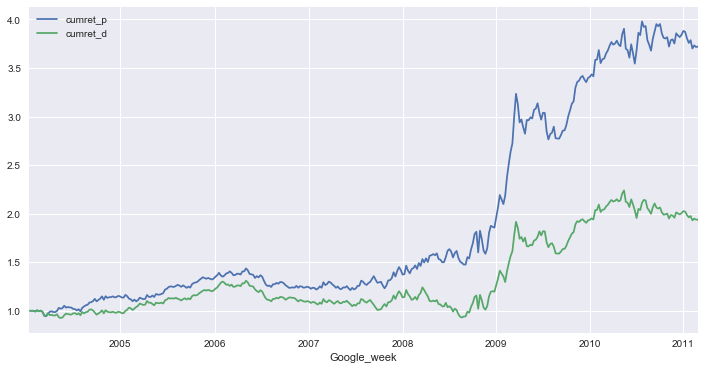

In [37]:
all_data[['cumret_p', 'cumret_d']].plot(figsize=(12,6));

声明：本资料仅供内部学习交流使用，切勿外传。